# Resolução - Projeto da Renner

# Bibliotecas

### Instalando e importando as bibliotecas necessárias

**geopy**: para o cálculo de distância entre coordenadas.

**pandas**: para criação e manipulação de dataframes.

**pulp**: para modelar e resolver problemas de programação linear.

**numpy**: para utilizar em conjunto com os dataframes do Pandas.

**matplotlib**: para plot de figuras.

**datetime**: para manipulação de datas.

**math**: biblioteca de funções matemáticas.

In [1]:
!pip install geopy
!pip install pulp

import pandas as pd
from pulp import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import geopy.distance
import datetime
import math

You should consider upgrading via the 'C:\Users\samir\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\samir\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Importando os dados da planilha de excel cedida pela Renner

In [2]:
df_CD = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Centro de Distribuição")
df_turnos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Turnos")
df_lojas = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Lojas')
df_demanda = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Demanda')
df_veiculos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Veiculos')

## Apresentação do Case

### Objetivo e contexto do Problema

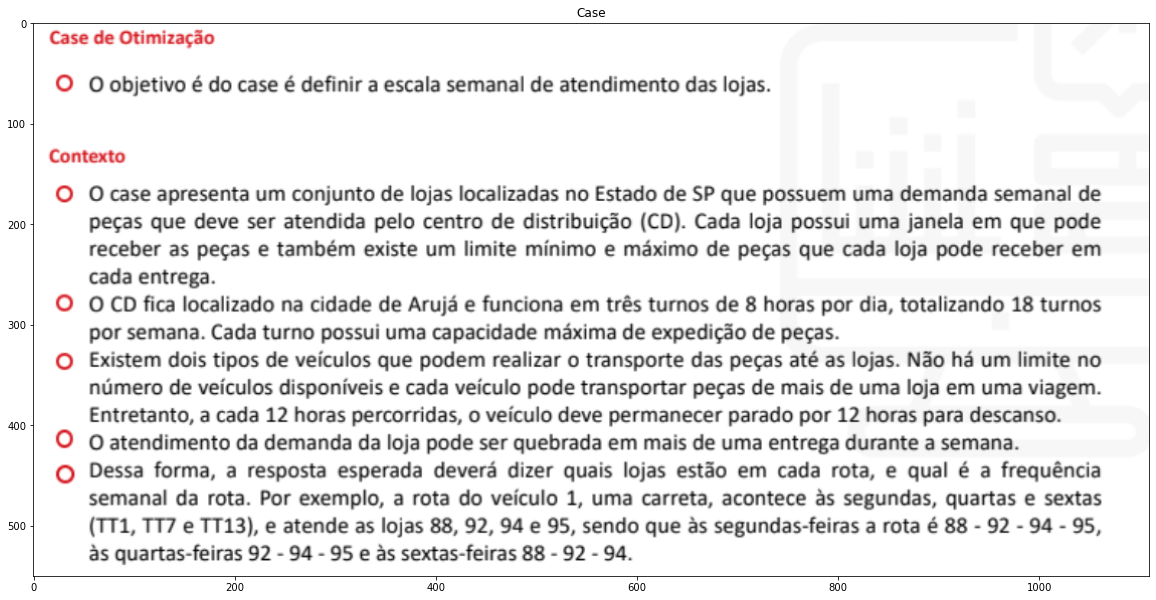

In [3]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Case")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/case.PNG")
plt.imshow(image)
plt.show()

### Restrições do Problema


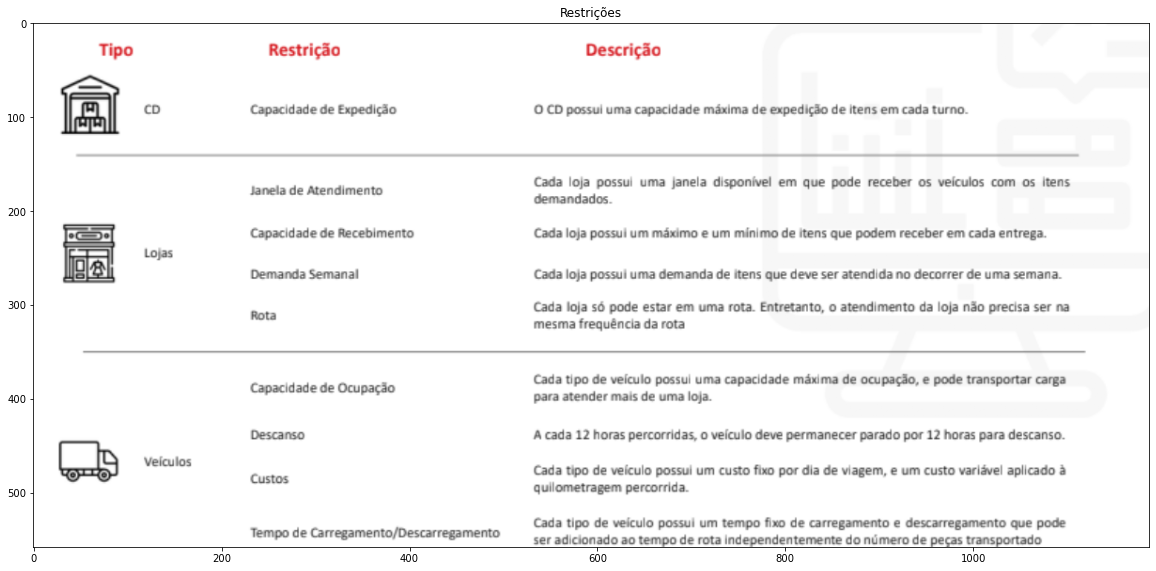

In [4]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Restrições")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/restrictions.PNG")
plt.imshow(image)
plt.show()

# Pré-processamento dos dados

### Unindo os dataframes do CD (Centro de Distribuição) e das lojas

In [5]:
df_lojas.head()

,ID Loja,Município,UF,Latitude,Longitude,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,1.0,BARUERI,SP,-23.504299,-46.834361,x,x,NaN,x,x,NaN,09:00:00,17:00:00,471.0,3138.0
1,2.0,SAO PAULO,SP,-23.529674,-46.676835,x,x,NaN,x,NaN,NaN,09:30:00,17:00:00,519.0,3455.0
2,3.0,SAO PAULO,SP,-23.626342,-46.656541,x,x,x,x,x,NaN,09:00:00,16:00:00,416.0,2773.0
3,4.0,BARUERI,SP,-23.496201,-46.812799,x,NaN,x,x,NaN,NaN,11:00:00,13:00:00,290.0,1931.0
4,5.0,SAO PAULO,SP,-23.541271,-46.575577,x,x,x,x,NaN,NaN,08:30:00,11:30:00,301.0,2006.0


In [6]:
df_CD

,Cidade,UF,Latitude,Longitude
0,Arujá,SP,-23.395082,-46.35536


In [7]:
cd_row = pd.DataFrame({'ID Loja': 0,
                        'Município':df_CD['Cidade'][0].upper(), 'UF':df_CD['UF'], 
                       'Latitude':df_CD['Latitude'][0], 'Longitude':df_CD['Longitude'],
                       'SEG': 'x','TER': 'x','QUA': 'x','QUI': 'x','SEX': 'x',
                       'SAB': 'x', 'Hora Recebimento Inicial': datetime.time(0, 0),
                       'Hora Finalização Recebimento': datetime.time(23, 59),
                       'Min. Peças p/ Entrega': 0,
                       'Máx. Peças p/ Entrega': 0,
                       })

In [8]:
df_lojas = pd.concat([cd_row,df_lojas.loc[:]]).reset_index(drop = True)

In [9]:
df_lojas.head(5)

,ID Loja,Município,UF,Latitude,Longitude,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,0.0,ARUJÁ,SP,-23.395082,-46.355360,x,x,x,x,x,x,00:00:00,23:59:00,0.0,0.0
1,1.0,BARUERI,SP,-23.504299,-46.834361,x,x,NaN,x,x,NaN,09:00:00,17:00:00,471.0,3138.0
2,2.0,SAO PAULO,SP,-23.529674,-46.676835,x,x,NaN,x,NaN,NaN,09:30:00,17:00:00,519.0,3455.0
3,3.0,SAO PAULO,SP,-23.626342,-46.656541,x,x,x,x,x,NaN,09:00:00,16:00:00,416.0,2773.0
4,4.0,BARUERI,SP,-23.496201,-46.812799,x,NaN,x,x,NaN,NaN,11:00:00,13:00:00,290.0,1931.0


### Obtendo a matriz de distâncias entre as coordenadas

In [10]:
def calculate_distance(coords_1: np.float64, coords_2: np.float64) -> float:
  return float(geopy.distance.geodesic(coords_1, coords_2).m)

In [11]:
def generate_distance_matrix(df: pd.core.frame.DataFrame) -> np.ndarray:
  distance_matrix = np.zeros((len(df), len(df)))
  for i in range(len(df)):
    for j in range(len(df)):
      coords_1 = (df['Latitude'].iloc[i], df['Longitude'].iloc[i])
      coords_2 = (df['Latitude'].iloc[j], df['Longitude'].iloc[j])
      distance_matrix[i][j] = calculate_distance(coords_1, coords_2)
  return distance_matrix

In [12]:
dmatrix = generate_distance_matrix(df_lojas)

### Limpando o dataframe das lojas para deixá-lo com apenas as informações que serão usadas adiante

In [13]:
df_lojas.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)

### Trocando 'x' por seu equivalente booleano na escala de atendimentos das lojas

In [14]:
# Para df_lojas, onde tem X ou x, singnifica que a Loja funciona. Logo, será substituído por 1. Em contrapartida, NaN será 0, pois a loja não funciona.
df_lojas_turnos = ['SEG', 'TER', 'QUA', 'QUI', 'SEX', 'SAB']

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('X', 1)
df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('x', 1)

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace(np.nan, 0)

### Tranformando as horas em **float** e transformando os '0's das horas de finalização em '24's, para criar uma escala de tempo adequada.

In [15]:
df_lojas['Hora Recebimento Inicial'] = df_lojas['Hora Recebimento Inicial'].apply(lambda x: x.hour + x.minute/60)
df_lojas['Hora Finalização Recebimento'] = df_lojas['Hora Finalização Recebimento'].apply(lambda x: x.hour + x.minute/60)
df_lojas['Hora Finalização Recebimento'] = df_lojas['Hora Finalização Recebimento'].apply(lambda x: float(24) if x == 0 else x)

## Modelagem do Problema

## Visualização dos dataframes disponíveis

### Turnos

In [16]:
df_turnos

,Turno,Capacidade Máxima de Expedição
0,TT1,53604.0
1,TT2,56820.0
2,TT3,40200.0
3,TT4,43233.0
4,TT5,49306.0
5,TT6,42067.0
6,TT7,48385.0
7,TT8,48360.0
8,TT9,42216.0
9,TT10,42855.0


### Lojas

In [17]:
df_lojas.head(3)

,ID Loja,Município,UF,SEG,TER,QUA,QUI,SEX,SAB,Hora Recebimento Inicial,Hora Finalização Recebimento,Min. Peças p/ Entrega,Máx. Peças p/ Entrega
0,0.0,ARUJÁ,SP,1.0,1.0,1.0,1.0,1.0,1.0,0.0,23.983333,0.0,0.0
1,1.0,BARUERI,SP,1.0,1.0,0.0,1.0,1.0,0.0,9.0,17.000000,471.0,3138.0
2,2.0,SAO PAULO,SP,1.0,1.0,0.0,1.0,0.0,0.0,9.5,17.000000,519.0,3455.0


### Lojas disponíveis por dia da semana:

In [18]:
lojas_SEG = list(dict(zip(df_lojas['ID Loja'], df_lojas['SEG'])).values())
lojas_TER = list(dict(zip(df_lojas['ID Loja'], df_lojas['TER'])).values())
lojas_QUA = list(dict(zip(df_lojas['ID Loja'], df_lojas['QUA'])).values())
lojas_QUI = list(dict(zip(df_lojas['ID Loja'], df_lojas['QUI'])).values())
lojas_SEX = list(dict(zip(df_lojas['ID Loja'], df_lojas['SEX'])).values())
lojas_SAB = list(dict(zip(df_lojas['ID Loja'], df_lojas['SAB'])).values())
stores_per_day = {'MON':lojas_SEG, 'TUE':lojas_TER, 'WED':lojas_QUA, 'THU':lojas_QUI, 'FRI':lojas_SEX, 'SAT':lojas_SAB}

### Demanda

In [19]:
df_demanda.head(3)

,Loja,Peças
0,1.0,3138.0
1,2.0,3455.0
2,3.0,2773.0


In [20]:
cd_demanda = pd.DataFrame({'Loja': [0], 'Peças': [0]})

df_demanda = pd.concat([cd_demanda,df_demanda.loc[:]]).reset_index(drop = True)

In [21]:
demanda = dict(zip(df_demanda['Loja'], df_demanda['Peças'])) # Conversão em dict para facilitar a adição de restrições

### Veículos

In [22]:
df_veiculos.head(3)

,Veículo,Capacidade Máxima (peças),Custo por km,Custo Fixo por dia de viagem,Velocidade,Tempo de carregamento (horas),Tempo de descarregamento (horas)
0,TOCO,5000.0,1.6,100.0,50km/h,0.5,0.5
1,CARRETA,10000.0,2.4,150.0,50km/h,1.0,1.0


#### Criação de dicionários para acesso mais fácil

In [23]:
custo_km = {'TOCO': 1.6, 'CARRETA': 2.4} # em reais/km
capacidade_max = {'TOCO': 5000, 'CARRETA': 10000} # em unidades
custos_fixos = {'TOCO': 100, 'CARRETA': 150} # em reais/km
velocidades = {'TOCO': 50000, 'CARRETA': 50000} # em metros/hora
carregamento = {'TOCO': 0.5, 'CARRETA': 1} # em horas
descarregamento = {'TOCO': 0.5, 'CARRETA': 1} # em horas

## Definindo as variáveis necessárias para a solução via programação linear usando o pulp

### Lista dos a_{i}, início da time window do cliente i

In [24]:
# a = list(df_lojas['Hora Recebimento Inicial'])
# print(a)

### Lista dos b_{i}, fim da time window do cliente i

In [25]:
# b = list(df_lojas['Hora Finalização Recebimento'])
# print(b)

### Lista com as demandas de cada cliente

In [26]:
# # O artigo chama essa lista de q
# # O cliente 0 é o CD, por conveniência

# q = list(demanda.values())
# print(q)

### Matriz de distâncias

In [27]:
# dmatrix

### Tempo Mínimo para percorrer a aresta (i,j), de i a j

In [28]:
# # O artigo chama essa matrix de d (dij)

# d = dmatrix/velocidades['TOCO'] # É a mesma coisa que dmatrix/velocidades['CARRETA'], pois possuem velocidades iguais.

# d # Tempos em horas.

### Outras variáveis

In [29]:
# # Numerando cada um dos nós do grafo.
# pontos = list(range(0, 134)) # len(pontos) = 134, vai de 0 (CD) a 133.

# # Número de clientes
# n = len(pontos) - 1 # n = 133 clientes.

# # Nomes dos veículos.
# veiculos = ['TOCO', 'CARRETA'] 

# # Definindo o conjunto K com n veículos 'TOCO' e n veículos 'CARRETA'.
# lista_veiculos = list(range(0, 2*n)) # Teremos 266 veículos.
# K = [k for k in lista_veiculos]

# # Definindo o conjunto Q_til com as capacidades dos veículos de K.
# Q_til = list()
# for i in range(0, n):
#   Q_til.append(capacidade_max['TOCO'])
# for i in range(n, 2*n):
#   Q_til.append(capacidade_max['CARRETA'])

# # Definindo os custos por km por veículo.
# c = list()
# for i in range(0, n):
#   c.append(custo_km['TOCO'])
# for i in range(n, 2*n):
#   c.append(custo_km['CARRETA'])

# # Definindo o conjunto F com os custos fixos dos veículos de K.
# F = list()
# for i in range(0, n):
#   F.append(custos_fixos['TOCO'])
# for i in range(n, 2*n):
#   F.append(custos_fixos['CARRETA'])

# # Definindo o conjunto v com as velocidades dos veículos de K.
# v = list()
# for i in range(0, n):
#   v.append(velocidades['TOCO'])
# for i in range(n, 2*n):
#   v.append(velocidades['CARRETA'])

# # Definindo Ftil, o custo fixo em termos de tempo.
# Ftil = list()
# for i in range(0, 2*n):
#   Ftil.append(F[i] / (c[i] * v[i]))

# # Definindo o conjunto sk com os tempos de serviço de cada veículo. 
# # (aqui associamos aos veículos, não aos clientes, diferente do artigo).
# s = list()
# for i in range(0, n):
#   s.append(carregamento['TOCO'] + descarregamento['TOCO'])
# for i in range(n, 2*n):
#   s.append(carregamento['CARRETA'] + descarregamento['CARRETA'])

# # Caminhos possíveis entre quaisquer dois pontos do grafo.
# Caminhos = [(i, j) for i in pontos for j in pontos]

In [30]:
# Variáveis binárias xijk que definem se uma rota é (xijk = 1) ou não (xijk = 0) percorrida.
#i_pontos = pontos
#j_pontos = pontos
#k_veiculos = K
#x = LpVariable.dicts("Rotas", (i_pontos, j_pontos, k_veiculos), cat=LpBinary)

In [31]:
# Variáveis binárias yik que definem se o cliente i é servido (yik = 1) ou não (yik = 0) pelo veículo k.
#i_pontos = pontos
#k_veiculos = K
#y = LpVariable.dicts("Clientes", (i_pontos, k_veiculos), cat=LpBinary)

In [32]:
# Variáveis binárias zk que definem se o veículo k é usado (zk = 1) ou não (zk = 0).
#k_veiculos = K
#z = LpVariable.dicts("Veiculos", (k_veiculos), cat=LpBinary)

In [33]:
# Variáveis reais tik que indicam o mínimo instante de tempo em que o veículo k
# pode possivelmente chegar no nó i.
#i_pontos = pontos
#k_veiculos = K
#t = LpVariable.dicts("Tempo_Minimo_Chegada", (k_veiculos, i_pontos), cat=LpContinuous)

In [34]:
# Variáveis reais tali que indicam o mínimo instante de tempo no qual 
# o serviço no cliente i pode começar.
#i_pontos = pontos
#tal = LpVariable.dicts("Inicio_Janela",(i_pontos), cat=LpContinuous)

In [35]:
# Variáveis reais pik para determinar o instante de tempo em que o veículo k,
# se usado, começa sua rota.
#k_veiculos = K
#pi = LpVariable.dicts("Inicio_Rota", (k_veiculos), cat=LpContinuous)

In [36]:
# Constante positiva muito grande, utilizada nas heurísticas.

#M = max(b) + max(s) + max(map(max, d))

#print(M) # M medida em horas.

## Modelando o problema com a biblioteca pulp

### Declarando o problema e a variável de decisão

In [37]:
# prob = LpProblem("Otimizacao_Renner", LpMinimize)

### Adicionando função objetivo ao problema de PL

In [38]:
# # o problema será resolvido em termos do tempo mínimo

# # (1)
# prob += (
#     # custos fixos em termos de tempo
#     lpSum([Ftil[k] for k in K]) + \
#     # tempo que chega da entrega
#     lpSum([t[k][0]] for k in K) - \
#     # tempo que sai da entrega
#     lpSum([pi[k]] for k in K) - \
#     # tempo necessário para carregar/descarregar
#     lpSum([s[i] for i in pontos])
# )

### Adicionando restrições ao problema

In [39]:
# Definição de y_ik
# for k in K:
# # y_ik = 1 se soma(x[i][j][k] para j em pontos[1:]) > 0, ou 0 cc
#   for i in pontos[1:]:
#     prob += (
#       lpSum([x[i][j][k] for j in pontos[1:]]) <= y[i][k]
#     )

#     prob += (
#         y[i][k] <= 1
#     )

In [40]:
# # Definição de z_k

# for k in K:
#   prob += (
#       lpSum([x[i][j][k] for (i, j) in Caminhos]) <= z[k]
#   )

#   prob += (
#       z[k] <= 1
#   )

In [41]:
# #(2)
# for i in pontos[1:]: 
#   prob += (
#       lpSum([y[i][k] for k in K]) == 1
#   )

In [42]:
# # (3)
# for i in pontos[1:]:
#   for k in K:
#     prob += (
#         lpSum([x[j][i][k] for j in pontos]) == y[i][k]
#     )

# # (4)
# for j in pontos[1:]:
#   for k in K:
#     prob += (
#         lpSum([x[i][j][k] for j in pontos]) == y[i][k]
#     )

In [43]:
# # (5)
# for k in K:
#   prob += (
#       lpSum([q[i]*y[i][k] for i in pontos]) <= Q_til[k] * z[k]
#   )

In [44]:
# # (7)
# for k in K:
#   for i in pontos:
#     prob += (
#         t[k][j] >= tal[i] + s[i] + d[i][j] - M*(1- x[i][j][k])
#     )

# # (8)
# for k in K:
#   for i in pontos:
#     prob += (
#         t[k][j] >= pi[k] + d[0][j] - M*(1-x[0][j][k])
#     )

In [45]:
# # (9)
# for k in K:
#   prob += (t[k][0] >= pi[k])

# # (10)
# for k in K:
#   for i in pontos:
#     prob += (tal[i] >= t[k][i])

# # (11)
# for i in pontos:
#   prob += (tal[i] >= a[i])
#   prob += (tal[i] <= b[i])

In [46]:
# # (15)
# for k in K:
#   for i in pontos:
#     prob += (t[k][i] >= 0)

# # (16)
# for i in pontos:
#   prob += (tal[i] >= 0)

# # (17)
# for k in K:
#   prob += (pi[k] >= 0)

## Resolvendo o problema de PL

In [47]:
# prob.solve()

Notamos que o tempo para resolução do problema modelado até agora é muito alto para os padrões buscados, após rodarmos a função prob.solve(). O próprio artigo-base utilizado indica que, de fato, os tempos para resolução do problema proposto, que foi modelado até agora com condições necessárias - mas não suficientes - para resolver o case, são, em média, muito elevados devido à grande ordem de complexidade do algoritmo de programação linear utilizado. Pode-se considerar ainda que o problema demorará mais para ser resolvido devido ao uso específico da linguagem Python. Nesse sentido, iremos buscar uma solução do problema através de algumas heurísticas, isto é, realizar o procedimento de resolução com uma abordagem mais "força bruta".

# Resolução via Heurísticas

## Heurísticas que serão utilizadas

### Heurística do vizinho mais próximo

**Passo-a-passo:**

1) Parte-se do depósito com um novo veículo até a cidade mais próxima.

2) Calcula-se a cidade mais próxima da última cidade inserida na rota e verifica-se se é possível atender sua demanada.

3) Se for possível atender a demanda dessa cidade, adiciona-se ela à rota. Do contrário, retorna-se o veículo ao depósito e volta-se ao passo 1.

### Outras Heurísticas

- Todos os veículos inicialmente são carretas, para que consigamos atender todas as lojas. Ao fim, será proposta (apesar de não realizada) uma otimização para trocar as carretas por tocos onde for possível.

- Todos os veículos atenderão as lojas logo que possível, isto é, nos turnos mais cedo. Caso não seja possível, atenderão em turnos mais tarde. Por conta disso, os turnos iniciais de cada dia serão preenchidos mais rapidamente.

- Os veículos partirão do Centro de Distribuição (CD) em turnos que estão localizados no mesmo dia em que as lojas podem ser atendidas. Caso não seja possível atender todas as lojas seguindo essa heurística, será realizada uma análise dos dados obtidos e um ajuste manual dos casos que não a respeitam.

### Implementação da função que localiza os n vizinhos mais próximos

In [48]:
def n_nearest_neighbors(n: int, i: int, dmatrix: np.ndarray) -> list:
    '''Acha o índice dos n vizinhos mais próximos da loja i e a distância mínima de cada um, dada a matriz de distâncias dmatrix.'''
    n_nearest = list()
    sorted_distances = sorted(dmatrix[i])
    if n >= len(sorted_distances):
        n = len(sorted_distances) - 1
    for j in range(0, n):
        n_distance = sorted_distances[j + 1]
        n_nearest.append([list(dmatrix[i]).index(n_distance), n_distance])
    return n_nearest

In [49]:
n_nearest_neighbors(5, 1, dmatrix)

[[67, 1059.5671188552806],
 [66, 1580.717827144746],
 [4, 2378.0530387172835],
 [64, 2709.0897218656814],
 [48, 5423.633171546491]]

### Definição de algumas variáveis globais úteis

In [50]:
capacidade_max_recebimento = dict(zip(df_lojas['ID Loja'], df_lojas['Máx. Peças p/ Entrega']))
print(capacidade_max_recebimento)

{0.0: 0.0, 1.0: 3138.0, 2.0: 3455.0, 3.0: 2773.0, 4.0: 1931.0, 5.0: 2006.0, 6.0: 2485.0, 7.0: 2047.0, 8.0: 1705.0, 9.0: 2663.0, 10.0: 2035.0, 11.0: 2398.0, 12.0: 1858.0, 13.0: 2640.0, 14.0: 2360.0, 15.0: 2775.0, 16.0: 2415.0, 17.0: 1948.0, 18.0: 3681.0, 19.0: 2009.0, 20.0: 1657.0, 21.0: 2358.0, 22.0: 2617.0, 23.0: 2623.0, 24.0: 2105.0, 25.0: 3033.0, 26.0: 2789.0, 27.0: 1937.0, 28.0: 2767.0, 29.0: 2148.0, 30.0: 2532.0, 31.0: 1479.0, 32.0: 2438.0, 33.0: 2827.0, 34.0: 2295.0, 35.0: 2098.0, 36.0: 1990.0, 37.0: 2374.0, 38.0: 2411.0, 39.0: 2882.0, 40.0: 2067.0, 41.0: 1689.0, 42.0: 2969.0, 43.0: 1432.0, 44.0: 2338.0, 45.0: 2027.0, 46.0: 2466.0, 47.0: 2242.0, 48.0: 1975.0, 49.0: 2190.0, 50.0: 2105.0, 51.0: 1979.0, 52.0: 2529.0, 53.0: 1747.0, 54.0: 2734.0, 55.0: 2473.0, 56.0: 1975.0, 57.0: 2250.0, 58.0: 1545.0, 59.0: 2329.0, 60.0: 4041.0, 61.0: 1618.0, 62.0: 2762.0, 63.0: 1215.0, 64.0: 5127.0, 65.0: 3672.0, 66.0: 4200.0, 67.0: 2531.0, 68.0: 8638.0, 69.0: 3000.0, 70.0: 6480.0, 71.0: 7821.0, 72.0

In [51]:
hora_recebimento_inicial = list(dict(zip(df_lojas['ID Loja'], df_lojas['Hora Recebimento Inicial'])).values())
print(hora_recebimento_inicial)

[0.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 6.5, 8.0, 9.0, 9.0, 6.0, 6.0, 8.0, 11.0, 6.0, 6.0, 10.0, 6.0, 13.0, 19.0, 8.0, 9.0, 8.0, 10.0, 9.0, 6.0, 10.0, 10.0, 10.0, 11.0, 6.0, 6.0, 9.0, 10.0, 0.0, 9.0, 9.0, 8.0, 6.0, 0.0, 6.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 9.0, 11.0, 0.0, 6.5, 8.0, 9.0, 0.0, 9.0, 10.0, 8.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 7.5, 8.0, 9.0, 10.0, 7.0, 11.0, 8.0, 11.0, 10.0, 19.0, 10.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 10.0, 11.0, 10.0, 13.0, 7.0, 14.0, 10.0, 9.0, 8.0, 10.0, 9.0, 7.0, 7.5, 7.5, 9.0, 10.0, 10.0, 11.0, 10.0, 6.0, 9.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 9.0, 9.0, 11.0, 9.0, 11.0, 10.0, 7.5, 7.5, 0.0, 8.0, 8.0, 10.0, 9.0, 7.0, 8.0, 10.0, 6.5, 7.5, 7.0, 16.0, 12.0, 13.0, 7.0]


In [52]:
hora_finalizacao_recebimento = list(dict(zip(df_lojas['ID Loja'], df_lojas['Hora Finalização Recebimento'])).values())
hora_finalizacao_recebimento[0] = float(24)
print(hora_finalizacao_recebimento)

[24.0, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 9.5, 13.0, 11.0, 12.0, 9.0, 12.0, 12.0, 15.0, 10.0, 10.0, 14.0, 9.5, 23.0, 23.0, 12.0, 12.0, 18.0, 15.0, 14.0, 10.0, 16.0, 14.0, 14.0, 17.0, 10.0, 10.0, 13.0, 14.0, 6.0, 14.0, 14.0, 13.0, 11.0, 9.0, 12.0, 10.0, 10.0, 11.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 8.0, 11.5, 18.0, 17.0, 6.0, 13.0, 13.0, 10.0, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 7.5, 13.0, 11.0, 12.0, 8.0, 12.0, 12.0, 15.0, 14.0, 20.0, 13.0, 13.0, 13.0, 14.0, 10.5, 9.0, 15.0, 12.0, 17.0, 11.0, 16.0, 9.0, 16.0, 14.0, 14.0, 9.0, 14.0, 16.0, 9.5, 10.0, 9.75, 11.0, 12.0, 14.0, 13.0, 12.0, 10.5, 18.0, 11.0, 13.0, 9.0, 24.0, 14.0, 12.0, 17.0, 15.0, 17.0, 12.5, 17.0, 14.0, 17.0, 16.0, 10.5, 10.5, 8.0, 10.5, 10.0, 17.0, 11.0, 10.0, 10.0, 13.0, 9.0, 11.0, 12.0, 21.0, 18.0, 24.0, 11.0]


- Agora temos acesso fácil às horas de recebimento inicial e final de cada loja.

In [53]:
print('Dados dos veículos\n')
print(f'Custo por km em R$: {custo_km}')
print(f'Capacidade máxima em unidades:{capacidade_max}')
print(f'Custos fixos em R$: {custos_fixos}')
print(f'Velocidades em m/h: {velocidades}')
print(f'Tempo de carregamento em h: {carregamento}')
print(f'Tempo de descarregamento em h: {descarregamento}')

Dados dos veículos

Custo por km em R$: {'TOCO': 1.6, 'CARRETA': 2.4}
Capacidade máxima em unidades:{'TOCO': 5000, 'CARRETA': 10000}
Custos fixos em R$: {'TOCO': 100, 'CARRETA': 150}
Velocidades em m/h: {'TOCO': 50000, 'CARRETA': 50000}
Tempo de carregamento em h: {'TOCO': 0.5, 'CARRETA': 1}
Tempo de descarregamento em h: {'TOCO': 0.5, 'CARRETA': 1}


- Agora temos visualização e acesso fácil aos dados dos veículos.

### Criação do objeto vehicle (veículo) para conseguirmos acessar e modificar as informações de cada um com facilidade

In [54]:
class vehicle:
    m_cost = 0
    max_capacity = 0
    fixed_cost = 0
    velocity = 0
    charge_time = 0
    discharge_time = 0
    
    def __init__(self, vehicle_index: int, start_time = 0, delivery_time = list(), current_load = max_capacity, current_cost = fixed_cost, current_work_time = charge_time, routes = {'MON': list(), 'TUE': list(), 'WED': list(), 'THU': list(), 'FRI': list(), 'SAT': list()}):
        self.vehicle_index = vehicle_index
        self.current_load = current_load
        self.current_cost = current_cost
        self.current_work_time = current_work_time
        self.routes = routes
        self.start_time = start_time
        self.delivery_time = delivery_time
        
    def get_vehicle_number(self):
        return self.vehicle_index
    
    def get_current_load(self):
        return self.current_load
    
    def get_current_cost(self):
        return self.current_cost
    
    def get_current_work_time(self):
        return self.current_work_time
    
    def get_routes(self):
        return self.routes

    def get_velocity(self):
        return self.velocity

    def get_charge_time(self):
        return self.charge_time

    def get_discharge_time(self):
        return self.discharge_time

    def get_start_time(self):
        return self.start_time
    
    def get_delivery_time(self):
        return self.delivery_time
    
    def get_m_cost(self):
        return self.m_cost
    
    def set_current_load(self, new_load):
        self.current_load = new_load
        
    def set_current_cost(self, new_cost):
        self.current_cost = new_cost
        
    def set_current_work_time(self, new_work_time):
        self.current_work = new_work_time
        
    def set_routes(self, new_routes):
        self.routes = new_routes

    def set_start_time(self, new_start_time):
        self.start_time = new_start_time
        
    def save_delivery_time(self):
        self.delivery_time.append(self.start_time + self.current_work_time)
        
    def reduce_load_while_discharging(self, store_load: float):
        '''Atualiza a carga do veículo após descarregar em uma loja, passada a carga que a loja necessita.'''
        self.current_load = self.current_load - store_load

    def increase_work_time(self, dmatrix, first_store_index, second_store_index):
        '''Atualiza o tempo de trabalho do veículo ao percorrer uma aresta entre duas lojas.'''
        self.current_work_time += dmatrix[first_store_index][second_store_index]/self.velocity + self.discharge_time
        
    def increase_cost(self, dmatrix, first_store_index, second_store_index):
        '''Atualiza o custo do veículo ao percorrer uma aresta entre duas lojas.'''
        self.current_cost = self.current_cost + dmatrix[first_store_index][second_store_index]*self.m_cost
        
    def add_store_to_route(self, day: str, store_index: int): # adicionamos aqui somente as lojas atendidas, não o CD.
        '''Adiciona o índice de uma loja às rotas do veículo.'''
        self.routes[day].append(store_index)

    def end_route(self,dmatrix,final_store_index):
        self.current_work_time += dmatrix[final_store_index][0]/self.velocity
        self.current_cost += dmatrix[final_store_index][0]*self.m_cost
        
    def get_necessary_initial_load(self, day, demand):
        s = 0
        for store in self.routes[day]:
            s += demand[store]
        return s
     
    @staticmethod
    def get_turns(day: str, beginning_hour: float) -> list:
        '''Dados os horários de começo e fim, e o dia, retorna os turnos que estão associados a esse intervalo de tempo.'''
        days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']
        day_index = days.index(day)
        if 0 <= beginning_hour < 8:
            turn_day = 1
        elif 8 <= beginning_hour < 16:
            turn_day = 2
        else:
            turn_day = 3
            
        turn = 3*day_index + turn_day
        return turn
    

In [55]:
class toco(vehicle):
    m_cost = 0.0016
    max_capacity = 5000 
    fixed_cost = 100
    velocity = 50000
    charge_time = 0.5
    discharge_time = 0.5 
    
    def __init__(self, vehicle_index: int, routes, delivery_time, start_time = 0, current_load = max_capacity, current_cost = fixed_cost, current_work_time = charge_time):
        self.vehicle_index = vehicle_index
        self.current_load = current_load
        self.current_cost = current_cost
        self.current_work_time = current_work_time
        self.routes = routes
        self.start_time = start_time
        self.delivery_time = delivery_time
    
    def __str__(self):
        return f'Número do veículo: {self.vehicle_index}\nTipo do veículo: TOCO\nCarga atual: {self.current_load}\nCusto atual: {self.current_cost}\nTempo de trabalho atual: {self.current_work_time}\nRotas do veículo na semana: {self.routes}'
    
    def get_type(self):
        return 'TOCO'

In [56]:
class carreta(vehicle):
    m_cost = 0.0024
    max_capacity = 10000
    fixed_cost = 150
    velocity = 50000
    charge_time = 1
    discharge_time = 1
    current_load = max_capacity
    current_cost = fixed_cost
    #{'MON': list(), 'TUE': list(), 'WED': list(), 'THU': list(), 'FRI': list(), 'SAT': list()}
    
    def __init__(self,vehicle_index: int, routes, delivery_time, start_time = 0, current_load = max_capacity, current_cost = fixed_cost, current_work_time = charge_time):
        self.vehicle_index = vehicle_index
        self.current_load = current_load
        self.current_cost = current_cost
        self.current_work_time = current_work_time
        self.routes = routes
        self.start_time = start_time
        self.delivery_time = delivery_time
    
    def __str__(self):
        return f'Número do veículo: {self.vehicle_index}\nTipo do veículo: CARRETA\nCarga atual: {self.current_load}\nCusto atual: {self.current_cost}\nTempo de trabalho atual: {self.current_work_time}\nRotas do veículo na semana: {self.routes}'
    
    def get_type(self):
        return 'CARRETA'

In [57]:
def get_next_store(n: int, demanda: list, dmatrix: np.ndarray, day: str, stores_per_day: dict) -> int:
    '''Retorna a loja mais próxima da loja i cuja demanda ainda não foi atendida, e que pode ser atendida no dia em questão'''
    closest_stores = n_nearest_neighbors(len(dmatrix),n,dmatrix)
    for i in range(0,len(dmatrix)-1):
        if demanda[closest_stores[i][0]] != 0 and stores_per_day[day][i] != 0:
            return closest_stores[i][0]
    return 0

In [58]:
def get_n_next_stores(n: int, i: int, demanda: list, dmatrix: np.ndarray, day: str, stores_per_day: dict) -> list:
    '''Retorna as n lojas mais próximas da loja i, que ainda não foram atendidas, e que podem ser atendidas no dia em questão'''
    stores = n_nearest_neighbors(len(dmatrix),i,dmatrix) # ordenadas por proximidade à loja i
    result = list()
    for j in range(0,len(dmatrix)-1):
        if demanda[stores[j][0]] != 0 and stores_per_day[day][j] != 0 and len(result) < n:
            result.append(stores[j][0])
    return result

In [59]:
def can_supply(current_store: int, next_store:int, v:vehicle, demanda:list, comeco:list, termino: list, cap_exp: int) -> bool:
    ''' Retorna se uma dada loja pode ser atendida pelo veículo v, saindo da current_store e indo à next_store.'''
    # A nova viagem não pode exceder a capacidade máxima de carga do veículo
    if demanda[next_store] > v.get_current_load():
        return False

    # o veículo não pode chegar antes da loja abrir
    if v.get_start_time() + v.get_current_work_time() + dmatrix[current_store][next_store]/ v.get_velocity() < comeco[next_store]:
        return False

    # o veículo não pode chegar na loja após o horario de fechamento
    if v.get_start_time() + v.get_current_work_time() + dmatrix[current_store][next_store]/ v.get_velocity() > termino[next_store]:
        return False

    # o tempo de uso total do veículo não pode ultrapassar o limite de 12 horas (incluindo o retorno ao depósito?)
    if v.get_current_work_time() + dmatrix[current_store][next_store]/ v.get_velocity() + v.get_discharge_time() + dmatrix[next_store][0]/ v.get_velocity() > 12:
        return False

    # A nova viagem não pode exceder a capacidade de expedição do turno
    if demanda[next_store] > cap_exp:
        return False
    
    return True

In [60]:
def ranked_by_cost(current_store: int, n_next_stores: list,v: vehicle,dmatrix: np.ndarray) -> list:
    ''' Retorna as n próximas lojas possíveis de serem atendidas por um veículo em ordem crescente de custo.'''
    costs = {}
    for i in range(0,len(n_next_stores)):
        costs[n_next_stores[i]] = (dmatrix[current_store][n_next_stores[i]] + dmatrix[n_next_stores[i]][0])*v.get_m_cost()
    result = sorted(costs.items(), key=lambda x:x[1])
    sorted_index = list()
    for r in result:
        sorted_index.append(r[0])
    return sorted_index

### Aplicando a heurística em forma de algoritmo para determinar uma solução

In [61]:
lista_demandas = list(demanda.values())

In [62]:
lista_demandas.index(max(lista_demandas))

77

In [63]:
max(lista_demandas)

10553.0

- Vemos, pelos dados, que a loja 77 é a única que não consegue ser atendida com uma única carreta.

In [64]:
# Substraindo 5000 do único carregamento que não pode ser atendido por um único veículo, para mandarmos um toco ao fim.
current_demand = list(demanda.values())
current_demand[77] -= 5000
cap_exp = list(df_turnos['Capacidade Máxima de Expedição'])
days = ('MON','TUE','WED','THU','FRI','SAT')
custo_total = 0
n = 1

vehicles = list()
for i in range(0, len(df_lojas['ID Loja']) - 1):
    vehicles.append(carreta(i, routes = {'MON': list(), 'TUE': list(), 'WED': list(), 'THU': list(), 'FRI': list(), 'SAT': list()}, delivery_time = list()))

current_store = 0

# Algoritmo
for v in vehicles:
    for day in days:
        #Reset do veículo no dia
        v.set_current_load(10000)
        v.set_current_work_time(0)
        
        #Primeira loja do dia
        next_store = get_next_store(current_store, current_demand, dmatrix, day, stores_per_day)
        v.set_start_time(hora_recebimento_inicial[next_store] - dmatrix[current_store][next_store]/ v.get_velocity() - v.get_charge_time()) 
        while can_supply(current_store,next_store,v,current_demand, hora_recebimento_inicial, hora_finalizacao_recebimento, cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1]):
            #Alterações do veículo
            v.add_store_to_route(day,next_store)
            v.reduce_load_while_discharging(current_demand[next_store])
            v.increase_cost(dmatrix,current_store,next_store)
            v.increase_work_time(dmatrix,current_store,next_store)
            v.save_delivery_time()
            
            #Alterações das lojas/CD
            cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1] -= current_demand[next_store]
            current_demand[next_store] = 0.0
            #Continuação do ciclo
            current_store = next_store
            n_next_stores = get_n_next_stores(n,current_store, current_demand, dmatrix, day, stores_per_day)
            n_next_stores = ranked_by_cost(current_store,n_next_stores,v,dmatrix)
            next_store = get_next_store(current_store,current_demand,dmatrix,day,stores_per_day)
            for store in n_next_stores:
                if can_supply(current_store,store,v,current_demand, hora_recebimento_inicial, hora_finalizacao_recebimento, cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1]):
                    next_store = store
                    break
            
        if len(v.routes[day]) > 0:
            #Finaliza rotas iniciadas, retornando-as para o CD
            v.end_route(dmatrix,current_store)
        v.set_current_load(0)
    custo_total += v.get_current_cost()

### Escrevendo o resultado final em uma forma mais visual

In [65]:
resultado_final = pd.DataFrame(columns = ['CD', 'LOJA', 'ROTA', 'DIA DA SEMANA', 'TURNO', 'PLAN. HORA', 'VOLUME PREVISTO', 'VEÍCULO'])
resultado_final

,CD,LOJA,ROTA,DIA DA SEMANA,TURNO,PLAN. HORA,VOLUME PREVISTO,VEÍCULO


In [66]:
for v in vehicles:
    delivery_number = 0
    for day in days:
        daily_route = v.get_routes()[day]
        for store in daily_route:
            delivery_time = v.get_delivery_time()[delivery_number]
            row = {'CD': 'Arujá', 
                   'LOJA': store, 
                   'ROTA': v.get_vehicle_number() + 1, 
                   'DIA DA SEMANA': day, 
                   'TURNO': vehicle.get_turns(day,delivery_time), 
                   'PLAN. HORA': delivery_time, 
                   'VOLUME PREVISTO': v.get_necessary_initial_load(day, lista_demandas), 
                   'VEÍCULO': v.get_type()}
            resultado_final = resultado_final.append(row, ignore_index = True)
            delivery_number += 1
# Mandando um toco adicional para a loja 77 em horário apropriado.
row_77 = {'CD': 'Arujá', 
          'LOJA': 77, 
          'ROTA': resultado_final['ROTA'].max() + 1, 
          'DIA DA SEMANA': 'FRI', 
          'TURNO': vehicle.get_turns('FRI', 11), 
          'PLAN. HORA': 11, 
          'VOLUME PREVISTO': 5000, 
          'VEÍCULO': 'TOCO'}
resultado_final = resultado_final.append(row_77, ignore_index = True)

### Traduzindo os dias da semana para o português

In [67]:
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'SEG' if x == 'MON' else x)
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'TER' if x == 'TUE' else x)
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'QUA' if x == 'WED' else x)
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'QUI' if x == 'THU' else x)
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'SEX' if x == 'FRI' else x)
resultado_final['DIA DA SEMANA'] = resultado_final['DIA DA SEMANA'].apply(lambda x: 'SAB' if x == 'SAT' else x)

### Transformando os horários em horas e minutos

In [68]:
def transform_to_hour_minute(x):
    if math.trunc(60*(x - math.trunc(x))) != 0:
        return f'{math.trunc(x)}:{math.trunc(60*(x - math.trunc(x)))}'
    return f'{math.trunc(x)}:00'

resultado_final['PLAN. HORA'] = resultado_final['PLAN. HORA'].apply(lambda x: transform_to_hour_minute(x))

### Verificando se todas as lojas foram atendidas com as heurísticas propostas

In [69]:
for values in resultado_final['LOJA'].sort_values():
    print(values)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
114
115
116
118
119
120
125
126
127
128
129
130
131
132
133


- Verificamos que nem todas as lojas foram atendidas

### Testando para vários valores de n para obtermos o maior número de lojas atendidas através das heurísticas propostas

In [70]:
# all_stores_for_all_n = list()
# len_for_each_n = list()
# # lista_custo_total = [0]
# for n in range(1, 134):
#     all_stores = list()
#     current_demand = list(demanda.values())
#     current_demand[77] -= 5000
#     cap_exp = list(df_turnos['Capacidade Máxima de Expedição'])
#     days = ('MON','TUE','WED','THU','FRI','SAT')
#     custo_total = 0

#     vehicles = list()
#     for i in range(0, len(df_lojas['ID Loja']) - 1):
#         vehicles.append(carreta(i, routes = {'MON': list(), 'TUE': list(), 'WED': list(), 'THU': list(), 'FRI': list(), 'SAT': list()}, delivery_time = list()))

#     current_store = 0

#     # Algoritmo
#     for v in vehicles:
#         for day in days:
#             v.set_current_load(10000)
#             v.set_current_work_time(0)

#             next_store = get_next_store(current_store, current_demand, dmatrix, day, stores_per_day)
#             v.set_start_time(hora_recebimento_inicial[next_store] - dmatrix[current_store][next_store]/ v.get_velocity() - v.get_charge_time()) 
#             while can_supply(current_store,next_store,v,current_demand, hora_recebimento_inicial, hora_finalizacao_recebimento, cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1]):
                
#                 v.add_store_to_route(day,next_store)
#                 v.reduce_load_while_discharging(current_demand[next_store])
#                 v.increase_cost(dmatrix,current_store,next_store)
#                 v.increase_work_time(dmatrix,current_store,next_store)
#                 v.save_delivery_time()

                
#                 cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1] -= current_demand[next_store]
#                 current_demand[next_store] = 0.0
               
#                 current_store = next_store
#                 n_next_stores = get_n_next_stores(n,current_store, current_demand, dmatrix, day, stores_per_day)
#                 n_next_stores = ranked_by_cost(current_store,n_next_stores,v,dmatrix)
#                 next_store = get_next_store(current_store,current_demand,dmatrix,day,stores_per_day)
#                 for store in n_next_stores:
#                     if can_supply(current_store,store,v,current_demand, hora_recebimento_inicial, hora_finalizacao_recebimento, cap_exp[vehicle.get_turns(day,v.get_start_time()) - 1]):
#                         next_store = store
#                         break

#             if len(v.routes[day]) > 0:
#                 v.end_route(dmatrix,current_store)
#             v.set_current_load(0)
#     for v in vehicles:
#         for day in days:
#             all_stores.extend(v.routes[day])
#     all_stores = sorted(all_stores)
#     len_for_each_n.append(len(all_stores))
#     all_stores_for_all_n.append(all_stores)
    
#         custo_total += v.get_current_cost()
#     lista_custo_total.append(custo_total)

In [71]:
# max(len_for_each_n)
# len_for_each_n.index(127)

- Descobrimos, portanto, que n = 1 é o que atende o maior número de lojas.

### Procurando as lojas não atendidas

In [72]:
lojas_atendidas = list()
for value in resultado_final['LOJA'].sort_values():
    lojas_atendidas.append(value)

In [73]:
lojas_nao_atendidas = list()
for i in range(1, 134):
    if i not in lojas_atendidas:
        lojas_nao_atendidas.append(i)

In [74]:
lojas_nao_atendidas

[113, 117, 121, 122, 123, 124]

- Notamos, da análise dos dados, que o algoritmo não conseguiu atender as lojas muito distantes e que deveriam ser atendidas por turnos do dia anterior.

- É impossível preencher esses valores através das heurísticas simplificadoras que utilizamos.

In [75]:
cap_exp

[306.0,
 2212.0,
 26634.0,
 37.0,
 4773.0,
 35870.0,
 1101.0,
 33411.0,
 42216.0,
 371.0,
 37854.0,
 39281.0,
 12868.0,
 51287.0,
 51739.0,
 31765.0,
 27690.0,
 51860.0]

In [76]:
dmatrix[0][113]/50000

10.786341111985438

- Notamos que outras heurísticas menos simplificadas deveriam ser aplicadas para conseguirmos atender todas as lojas. Porém, como o número de lojas não atendidas é muito pequeno, conseguiremos preencher manualmente esses valores.

### Preenchendo esses valores na "força-bruta"

In [77]:
lojas_nao_atendidas

[113, 117, 121, 122, 123, 124]

In [78]:
row_113 = {'CD': 'Arujá', 
          'LOJA': 113, 
          'ROTA': resultado_final['ROTA'].max() + 1, 
          'DIA DA SEMANA': 'SEX', 
          'TURNO': 12, 
          'PLAN. HORA': '11:00', 
          'VOLUME PREVISTO': 3344, 
          'VEÍCULO': 'TOCO'}
resultado_final = resultado_final.append(row_113, ignore_index = True)

In [79]:
dmatrix[0][113]/50000

10.786341111985438

In [80]:
cap_exp[11] -= 3344

In [81]:
row_117 = {'CD': 'Arujá', 
          'LOJA': 117, 
          'ROTA': resultado_final['ROTA'].max() + 1, 
          'DIA DA SEMANA': 'QUA', 
          'TURNO': 9, 
          'PLAN. HORA': '7:30', 
          'VOLUME PREVISTO': 1012, 
          'VEÍCULO': 'TOCO'}
resultado_final = resultado_final.append(row_117, ignore_index = True)

In [82]:
dmatrix[0][117]/50000

9.763683247976486

In [83]:
cap_exp[8] -= 1012

In [84]:
row_121 = {'CD': 'Arujá', 
          'LOJA': 121, 
          'ROTA': resultado_final['ROTA'].max(), 
          'DIA DA SEMANA': 'QUI', 
          'TURNO': 9, 
          'PLAN. HORA': '8:00', 
          'VOLUME PREVISTO': 3371, 
          'VEÍCULO': 'CARRETA'}
resultado_final = resultado_final.append(row_121, ignore_index = True)

In [85]:
dmatrix[0][121]/50000

8.441141298106489

In [86]:
cap_exp[8] -= 3371

In [87]:
row_122 = {'CD': 'Arujá', 
          'LOJA': 122, 
          'ROTA': resultado_final['ROTA'].max(), 
          'DIA DA SEMANA': 'QUI', 
          'TURNO': 9, 
          'PLAN. HORA': '10:00', 
          'VOLUME PREVISTO': 2122, 
          'VEÍCULO': 'CARRETA'}
resultado_final = resultado_final.append(row_122, ignore_index = True)

In [88]:
dmatrix[0][122]/50000

8.463356765156382

In [89]:
cap_exp[8] -= 2122

In [90]:
row_123 = {'CD': 'Arujá', 
          'LOJA': 123, 
          'ROTA': resultado_final['ROTA'].max() + 1, 
          'DIA DA SEMANA': 'QUI', 
          'TURNO': 9, 
          'PLAN. HORA': '9:00', 
          'VOLUME PREVISTO': 9103, 
          'VEÍCULO': 'CARRETA'}
resultado_final = resultado_final.append(row_123, ignore_index = True)

In [91]:
dmatrix[0][123]/50000

8.459036285920547

In [92]:
cap_exp[8] -= 9103

In [93]:
row_124 = {'CD': 'Arujá', 
          'LOJA': 124, 
          'ROTA': resultado_final['ROTA'].max() + 1, 
          'DIA DA SEMANA': 'SEX', 
          'TURNO': 12, 
          'PLAN. HORA': '7:00', 
          'VOLUME PREVISTO': 5227, 
          'VEÍCULO': 'CARRETA'}
resultado_final = resultado_final.append(row_124, ignore_index = True)

In [94]:
dmatrix[0][124]/50000

7.731877252140808

In [95]:
cap_exp[11] -= 5227

## Finalmente, a resposta final do problema

In [96]:
resultado_final

,CD,LOJA,ROTA,DIA DA SEMANA,TURNO,PLAN. HORA,VOLUME PREVISTO,VEÍCULO
0,Arujá,129,1,SEG,2,8:00,3983.0,CARRETA
1,Arujá,74,2,SEG,3,20:00,9196.0,CARRETA
2,Arujá,76,2,TER,5,13:26,7510.0,CARRETA
3,Arujá,71,2,QUA,8,11:57,7821.0,CARRETA
4,Arujá,60,2,QUI,11,14:57,4041.0,CARRETA
...,...,...,...,...,...,...,...,...
129,Arujá,117,56,QUA,9,7:30,1012.0,TOCO
130,Arujá,121,56,QUI,9,8:00,3371.0,CARRETA
131,Arujá,122,56,QUI,9,10:00,2122.0,CARRETA
132,Arujá,123,57,QUI,9,9:00,9103.0,CARRETA


In [97]:
cap_exp

[306.0,
 2212.0,
 26634.0,
 37.0,
 4773.0,
 35870.0,
 1101.0,
 33411.0,
 26608.0,
 371.0,
 37854.0,
 30710.0,
 12868.0,
 51287.0,
 51739.0,
 31765.0,
 27690.0,
 51860.0]

In [98]:
custo_total += ((dmatrix[0][113] + dmatrix[113][0]) * 0.0016 
             + (dmatrix[0][117] + dmatrix[117][0]) * 0.0016 
             + (dmatrix[0][121] + dmatrix[121][122] + dmatrix[122][0])*0.0024 
             + (dmatrix[0][123] + dmatrix[123][0]) * 0.0024 
             + (dmatrix[0][124] + dmatrix[124][0])* 0.0024 
             + (100) + (100) + (150) + (150) + (150))

In [99]:
custo_total

56745.02586032057

In [100]:
resultado_final.to_excel('resultado_final_case_renner.xlsx')